# Import libraries

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split  # Ensure TensorDataset is imported here
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Preprocess Data

In [16]:
# CALCULATE COST

def calculate_window_cost(windows_U_Factor):
    if windows_U_Factor == 2.7:
        return 0
    elif windows_U_Factor == 1.0:
        return 184
    elif windows_U_Factor == 1.6:
        return 485
    elif windows_U_Factor == 1.2:
        return 295
    elif windows_U_Factor == 1.5:
        return 622
    else:
        return 0  # Default

def calculate_floor_cost(groundfloor_thickness):
    if groundfloor_thickness == 0.08:
        return 59.7
    elif groundfloor_thickness == 0.09:
        return 77
    elif groundfloor_thickness == 0.1:
        return 87.9
    elif groundfloor_thickness == 0.13:
        return 108
    else:
        return 0

def calculate_facade_cost(ext_walls_thickness):
    if ext_walls_thickness == 0.05:
        return 182
    elif ext_walls_thickness == 0.1:
        return 179
    elif ext_walls_thickness == 0.13:
        return 200
    elif ext_walls_thickness == 0.21:
        return 222
    else:
        return 0

def calculate_roof_cost(roof_thickness):
    if roof_thickness == 0.08:
        return 89.5
    elif roof_thickness == 0.11:
        return 105
    elif roof_thickness == 0.185:
        return 101
    elif roof_thickness == 0.23:
        return 139
    else:
        return 0

# Calculate total cost
def calculate_total_cost(row):
    window_cost = calculate_window_cost(row['windows_U_Factor'])
    floor_cost = calculate_floor_cost(row['groundfloor_thermal_resistance'])
    facade_cost = calculate_facade_cost(row['ext_walls_thermal_resistance'])
    roof_cost = calculate_roof_cost(row['roof_thermal_resistance'])
    return window_cost + floor_cost + facade_cost + roof_cost

In [17]:
# CALCULATE CARBON

def calculate_window_carbon(windows_U_Factor):
        if windows_U_Factor == 2.7:
            return 0
        elif windows_U_Factor == 1.0:
            return 70
        elif windows_U_Factor == 1.6:
            return 50
        elif windows_U_Factor == 1.2:
            return 150
        elif windows_U_Factor == 1.5:
            return 120
        else:
            return 0

def calculate_floor_carbon(groundfloor_thickness):
        if groundfloor_thickness == 0.08:
            return 10
        elif groundfloor_thickness == 0.09:
            return 6
        elif groundfloor_thickness == 0.1:
            return 11
        elif groundfloor_thickness == 0.13:
            return 7
        else:
            return 0

def calculate_facade_carbon(ext_walls_thickness):
        if ext_walls_thickness == 0.05:
            return 9
        elif ext_walls_thickness == 0.1:
            return 5
        elif ext_walls_thickness == 0.13:
            return 17
        elif ext_walls_thickness == 0.21:
            return 9
        else:
            return 0

def calculate_roof_carbon(roof_thickness):
        if roof_thickness == 0.08:
            return 23
        elif roof_thickness == 0.11:
            return 5
        elif roof_thickness == 0.185:
            return 18
        elif roof_thickness == 0.23:
            return 11
        else:
            return 0
        
# Calculate total carbon
def calculate_total_carbon(row):
        window_carbon = calculate_window_carbon(row['windows_U_Factor'])
        floor_carbon = calculate_floor_carbon(row['groundfloor_thermal_resistance'])
        facade_carbon = calculate_facade_carbon(row['ext_walls_thermal_resistance'])
        roof_carbon = calculate_roof_carbon(row['roof_thermal_resistance'])
        return window_carbon + floor_carbon + facade_carbon + roof_carbon

In [ ]:
# Load the CSV file
file_path = r'C:\Users\isabella.lucchese\Desktop\Graduation\Excel sheets\Inputs\Input Amin gives me for MTL\merged_output_SC_2024.csv'
df = pd.read_csv(file_path)

# Inputs 
df_inputs = pd.DataFrame()
df_inputs = pd.DataFrame(columns=['windows_U_Factor', 'groundfloor_thermal_resistance', 'ext_walls_thermal_resistance', 'roof_thermal_resistance'])
# Aggregate data
df_outputs = pd.DataFrame()
df_outputs = pd.DataFrame(columns=['building_id', "annual_energy_consumption", "total_cost", "total_carbon_emission", "comfort_days"])

# Columns corresponding to daily values (which should be summed to get annual consumption)
date_columns = [col for col in df.columns if col.startswith('2024-')]

for building_id, group in df.groupby('Building ID'):

    # Inputs
    df_inputs = df_inputs.append(
        {
            "windows_U_Factor":group['windows_U_Factor'].iloc[0],
            "groundfloor_thermal_resistance":group['groundfloor_thermal_resistance'].iloc[0],
            "ext_walls_thermal_resistance":group['ext_walls_thermal_resistance'].iloc[0],
            "roof_thermal_resistance": group['roof_thermal_resistance'].iloc[0]
        }, ignore_index=True
    )



    # Extract rows for energy types, handling missing rows
    electricity_building = group[group['index'].str.contains('Electricity Building')].iloc[0] if not group[group['index'].str.contains('Electricity Building')].empty else None
    electricity_facility = group[group['index'].str.contains('Electricity Facility')].iloc[0] if not group[group['index'].str.contains('Electricity Facility')].empty else None
    gas_consumption = group[group['index'].str.contains('Gas Consumption')].iloc[0] if not group[group['index'].str.contains('Gas Consumption')].empty else None
    indoor_temperature=group[group['index'].str.contains('Zone Mean Air Temperature ')].iloc[0] if not group[group['index'].str.contains('Zone Mean Air Temperature ')].empty else None

    # If all energy rows exist, calculate the annual sum
    if electricity_building is not None and electricity_facility is not None and gas_consumption is not None:
        # Create a new row for the building's annual energy consumption
        #annual_sum = electricity_building.copy()
        
        # Sum the values across all daily columns (2024-01-01 to 2024-12-31)
        annual_energy_consumption = (electricity_building[date_columns].sum() + 
                            electricity_facility[date_columns].sum() + 
                            gas_consumption[date_columns].sum())
    
    total_cost = calculate_window_cost(group['windows_U_Factor'].iloc[0])+ calculate_floor_cost(group['groundfloor_thickness'].iloc[0])+calculate_facade_cost(group['ext_walls_thickness'].iloc[0])+calculate_roof_cost(group['roof_thickness'].iloc[0])
    comfort_days = len([item for item in indoor_temperature[date_columns].values if 18<item<24])
    
    total_carbon_emission = calculate_window_carbon(group['windows_U_Factor'].iloc[0])+ calculate_floor_carbon(group['groundfloor_thickness'].iloc[0])+calculate_facade_carbon(group['ext_walls_thickness'].iloc[0])+calculate_roof_carbon(group['roof_thickness'].iloc[0])
    df_outputs = df_outputs.append(

    
        {
            "building_id": int(building_id), 
            "annual_energy_consumption": annual_energy_consumption, 
            "total_cost": total_cost, 
            "total_carbon_emission": total_carbon_emission,
            "comfort_days": comfort_days
            }, ignore_index=True

    )
    

In [29]:
df_outputs

,building_id,annual_energy_consumption,total_cost,total_carbon_emission,comfort_days
0,17000000.0,1.024608e+13,331.2,42.0,229.0
1,17000216.0,1.136412e+13,953.2,162.0,271.0
2,17000432.0,1.161261e+13,816.2,92.0,293.0
3,17000648.0,1.133897e+13,626.2,192.0,273.0
4,17000864.0,1.149528e+13,515.2,112.0,297.0


In [30]:
df_inputs

,windows_U_Factor,groundfloor_thermal_resistance,ext_walls_thermal_resistance,roof_thermal_resistance
0,2.7,1.15,1.53,1.5
1,1.5,1.15,1.53,1.5
2,1.6,1.15,1.53,1.5
3,1.2,1.15,1.53,1.5
4,1.0,1.15,1.53,1.5


# Load and Preprocess data


In [31]:
# Step 1: Load Your Training Data


# Separate inputs and outputs
X_data = df_inputs.values
Y_data = df_outputs[['annual_energy_consumption', 'total_cost', 'total_carbon_emission', 'comfort_days']].values

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_data, dtype=torch.float32)
Y_tensor = torch.tensor(Y_data, dtype=torch.float32)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)





# Define MTL model

In [32]:
class MultiTaskRegressionModel(nn.Module):
    def __init__(self, input_dim, shared_dim, task_dim, num_tasks):
        super(MultiTaskRegressionModel, self).__init__()
        
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(input_dim, shared_dim),
            nn.ReLU(),
            nn.Linear(shared_dim, shared_dim),
            nn.ReLU()
        )
        
        # Separate heads for each regression task
        self.heads = nn.ModuleList([nn.Linear(shared_dim, task_dim) for _ in range(num_tasks)])

    def forward(self, x):
        shared_output = self.shared(x)
        outputs = [head(shared_output) for head in self.heads]
        return torch.cat(outputs, dim=1)

# Instantiate the model
input_dim = 4  # Four input features
shared_dim = 64  # Dimension of shared layers
task_dim = 1  # Each head outputs a single continuous value
num_tasks = 4  # Predict four quantities: annual_energy_consumption, total_cost, total_carbon_emission, comfort_days

model = MultiTaskRegressionModel(input_dim, shared_dim, task_dim, num_tasks)



# Define Loss function and Optimizer


In [33]:
# Step 3: Define Loss Function and Optimizer for Regression
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop

In [34]:
# Step 4: Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= train_size
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}')

Epoch 1/20, Loss: 31284292137362862110670848.0000
Epoch 2/20, Loss: 31284292137362862110670848.0000
Epoch 3/20, Loss: 31284292137362862110670848.0000
Epoch 4/20, Loss: 31284292137362862110670848.0000
Epoch 5/20, Loss: 31284292137362862110670848.0000
Epoch 6/20, Loss: 31284292137362862110670848.0000
Epoch 7/20, Loss: 31284292137362862110670848.0000
Epoch 8/20, Loss: 31284292137362862110670848.0000
Epoch 9/20, Loss: 31284292137362862110670848.0000
Epoch 10/20, Loss: 31284292137362862110670848.0000
Epoch 11/20, Loss: 31284292137362862110670848.0000
Epoch 12/20, Loss: 31284292137362862110670848.0000
Epoch 13/20, Loss: 31284292137362862110670848.0000
Epoch 14/20, Loss: 31284292137362862110670848.0000
Epoch 15/20, Loss: 31284292137362862110670848.0000
Epoch 16/20, Loss: 31284292137362862110670848.0000
Epoch 17/20, Loss: 31284292137362862110670848.0000
Epoch 18/20, Loss: 31284292137362862110670848.0000
Epoch 19/20, Loss: 31284292137362862110670848.0000
Epoch 20/20, Loss: 312842921373628621106

# Validation Loop

In [35]:
# Step 5: Validation Loop
model.eval()
val_loss = 0.0
with torch.no_grad():
    for X_batch, Y_batch in val_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        val_loss += loss.item() * X_batch.size(0)

val_loss /= val_size
print(f'Validation Loss: {val_loss:.4f}')

Validation Loss: 32285802766612701087006720.0000


# Model evaluation on a New Input Vector

In [36]:
# Step 6: Model Evaluation on a New Input Vector
# Define a new input vector for testing
input_vector = [0.5, 2.5, 1.2, 3.1]  # Example input vector (windows_U_Factor, groundfloor_thermal_resistance, etc.)

# Prepare input tensor
input_tensor = torch.tensor(input_vector, dtype=torch.float32).unsqueeze(0)

# Evaluate the model on this input
model.eval()
with torch.no_grad():
    output = model(input_tensor)

# Extract and print output
output_values = output.numpy().flatten()
print("Predicted values for annual_energy_consumption, total_cost, total_carbon_emission, comfort_days:", output_values)

Predicted values for annual_energy_consumption, total_cost, total_carbon_emission, comfort_days: [2.1593394  0.03409124 0.94329447 0.8066077 ]


# Plot graph

Epoch 1/20, Training Loss: 31284292137362862110670848.0000, Validation Loss: 32285802766612701087006720.0000
Epoch 2/20, Training Loss: 31284292137362862110670848.0000, Validation Loss: 32285802766612701087006720.0000
Epoch 3/20, Training Loss: 31284292137362862110670848.0000, Validation Loss: 32285802766612701087006720.0000
Epoch 4/20, Training Loss: 31284292137362862110670848.0000, Validation Loss: 32285802766612701087006720.0000
Epoch 5/20, Training Loss: 31284292137362862110670848.0000, Validation Loss: 32285802766612701087006720.0000
Epoch 6/20, Training Loss: 31284292137362862110670848.0000, Validation Loss: 32285802766612701087006720.0000
Epoch 7/20, Training Loss: 31284292137362862110670848.0000, Validation Loss: 32285802766612701087006720.0000
Epoch 8/20, Training Loss: 31284292137362862110670848.0000, Validation Loss: 32285802766612701087006720.0000
Epoch 9/20, Training Loss: 31284292137362862110670848.0000, Validation Loss: 32285802766612701087006720.0000
Epoch 10/20, Traini

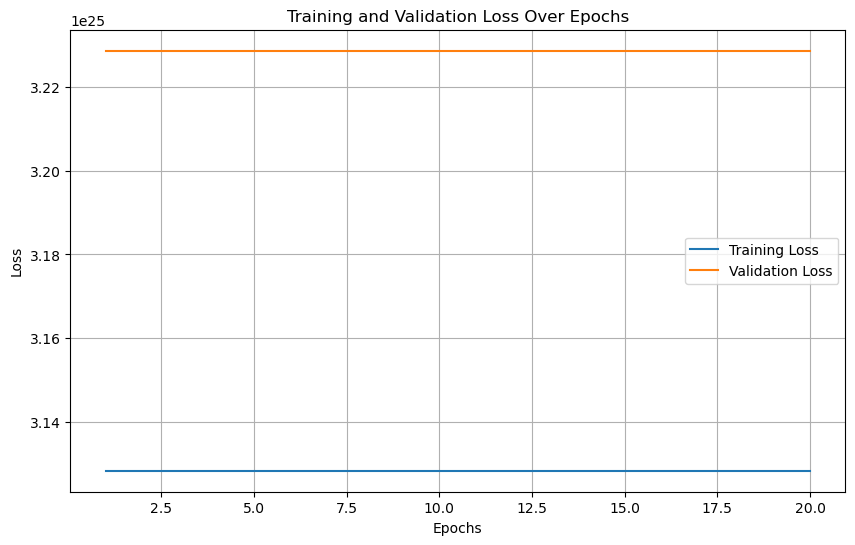

In [37]:
import matplotlib.pyplot as plt

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

# Training and Validation Loop with Loss Tracking
num_epochs = 20
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= train_size
    train_losses.append(train_loss)  # Store training loss for this epoch

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= val_size
    val_losses.append(val_loss)  # Store validation loss for this epoch

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
